In [1]:
import sys
from pathlib import Path

# Add the parent directory to Python path so we can import uuv_mission
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

# Add relevant Jupyter notebook extensions
%load_ext autoreload
%autoreload 2

In [2]:
# You can double-check your Python path like this...
import sys  
print(sys.path)

['/Users/supremedictator/Desktop/Github Repo/SupremeDictatorI/Engineering Science/B1 Engineering Computation/B1-Coding-Practical-UUV', '/opt/homebrew/Caskroom/miniforge/base/envs/B1/lib/python314.zip', '/opt/homebrew/Caskroom/miniforge/base/envs/B1/lib/python3.14', '/opt/homebrew/Caskroom/miniforge/base/envs/B1/lib/python3.14/lib-dynload', '', '/opt/homebrew/Caskroom/miniforge/base/envs/B1/lib/python3.14/site-packages']


# Simulate closed-loop
After implementing your control functionality, you can simulate the closed-loop with code that looks something like this...

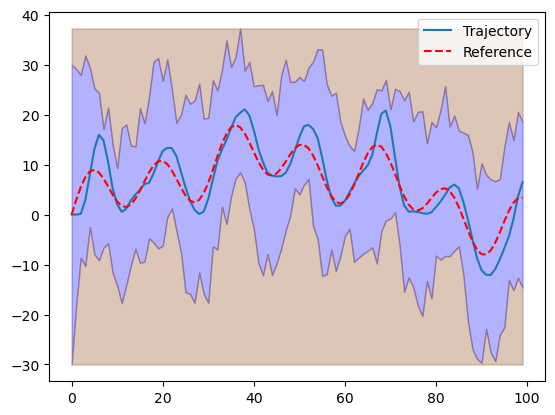

In [3]:
# Import relevant modules
from uuv_mission.control import Controller
from uuv_mission.dynamic import Submarine, Mission, ClosedLoop, Trajectory

sub = Submarine()
controller = Controller(KP=0.15, KD=0.6)

# Instantiate your controller (depending on your implementation)
closed_loop = ClosedLoop(sub, controller)
mission = Mission.from_csv("../data/mission.csv") # You must implement this method in the Mission class

trajectory = closed_loop.simulate_with_random_disturbances(mission)
trajectory.plot_completed_mission(mission)

# Optimise KP and KD Parameters
Test different combinations of KP and KD values to find the optimal parameters that minimize mean square error (MSE).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from uuv_mission.control import Controller
from uuv_mission.dynamic import Submarine, Mission, ClosedLoop, Trajectory

# Load the mission
sub = Submarine()
mission = Mission.from_csv("../data/mission.csv")

# Generate a fixed set of disturbances for consistent comparison
np.random.seed(42) 
fixed_disturbances = np.random.normal(0, 0.5, len(mission.reference))

# Define the range of KP and KD values to test
KP_range = np.linspace(0.01, 1, 100)
KD_range = np.linspace(0.01, 1, 100)

# Store results
best_mse = float('inf')
best_KP = None
best_KD = None


# Test all combinations
for i, KP in enumerate(KP_range):
    
    for j, KD in enumerate(KD_range):
        
        # Create controller with current KP and KD
        controller = Controller(KP=KP, KD=KD)
        closed_loop = ClosedLoop(sub, controller)
        
        # Simulate with fixed disturbances
        trajectory = closed_loop.simulate(mission, fixed_disturbances)
        
        # Calculate MSE (Mean Square Error) between trajectory and reference - MSE to get a + value
        errors = trajectory.position[:, 1] - mission.reference
        mse = np.mean(errors ** 2)
        
        # Update best parameters if this MSE is lower
        if mse < best_mse:
            best_mse = mse
            best_KP = KP
            best_KD = KD

# Print the optimal KP and KD values
print(f"Optimal KP: {best_KP}, Optimal KD: {best_KD}, with MSE: {best_mse}")

Optimal KP: 0.09, Optimal KD: 0.76, with MSE: 8.78022172316094


# Optimised vs Original Parameters (for the same disturbance)

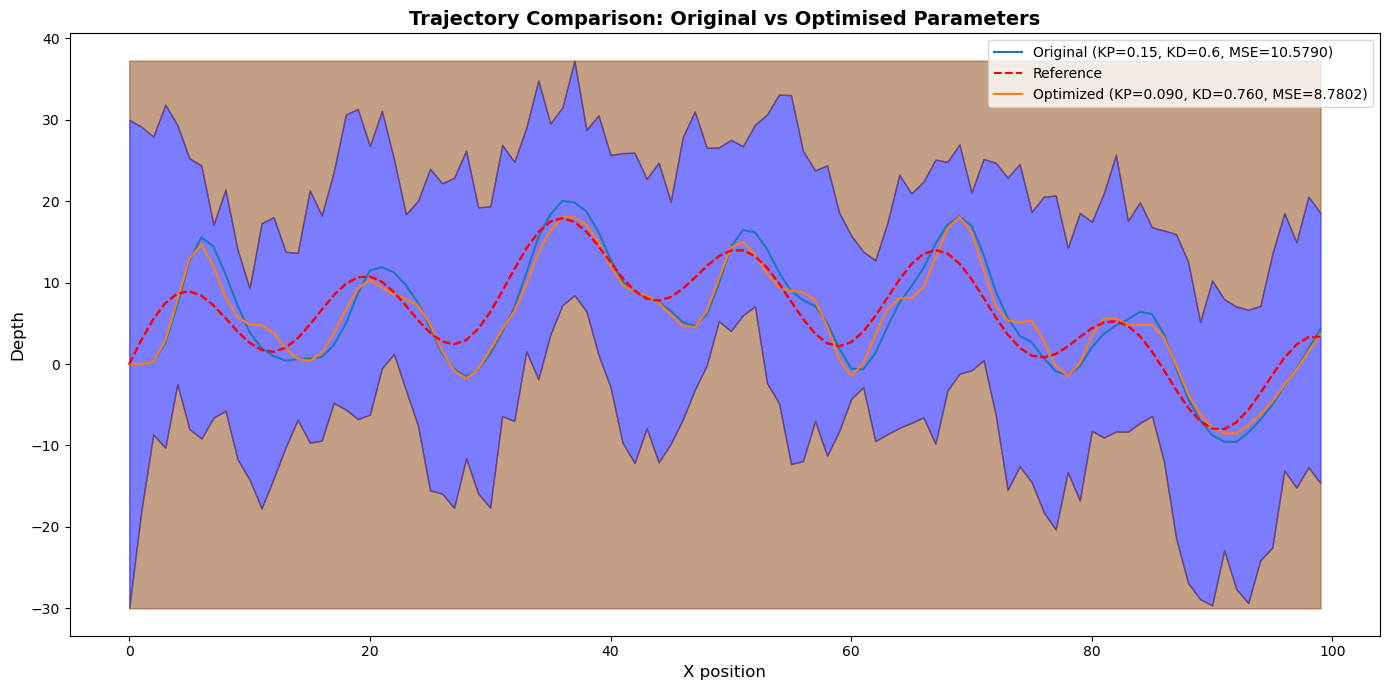

Optimised trajectory is 17.00% better than the original


In [6]:
# Original paramters simulation - disturbances must be the same for comparison
og_controller = Controller(KP=0.15, KD=0.6)
og_closed_loop = ClosedLoop(sub, og_controller)
og_trajectory = og_closed_loop.simulate(mission, fixed_disturbances)

# Optimised parameters simulation - disturbances must be the same for comparison
opt_controller = Controller(KP=best_KP, KD=best_KD)
opt_closed_loop = ClosedLoop(sub, opt_controller)
opt_trajectory = opt_closed_loop.simulate(mission, fixed_disturbances)

# Calculate MSE for both trajectories
og_errors = og_trajectory.position[:, 1] - mission.reference
og_mse = np.mean(og_errors ** 2)
opt_errors = opt_trajectory.position[:, 1] - mission.reference
opt_mse = np.mean(opt_errors ** 2)
# Plot both on the same figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both
og_trajectory.plot_completed_mission(mission, ax=ax, show=False, label=f'Original (KP=0.15, KD=0.6, MSE={og_mse:.4f})')
opt_trajectory.plot_completed_mission(mission, ax=ax, show=False, label=f'Optimized (KP={best_KP:.3f}, KD={best_KD:.3f}, MSE={opt_mse:.4f})')

# Changed legend labels to distinguish between original and optimized
handles, labels = ax.get_legend_handles_labels()

# Remove duplicate reference lines and update labels
both_labels = []
both_handles = []
for handle, label in zip(handles, labels):
    if label not in both_labels:
        both_labels.append(label)
        both_handles.append(handle)

ax.legend(both_handles, both_labels, loc='upper right')
ax.set_title('Trajectory Comparison: Original vs Optimised Parameters', fontsize=14, fontweight='bold')
ax.set_xlabel('X position', fontsize=12)
ax.set_ylabel('Depth', fontsize=12)

plt.tight_layout()
plt.show()

# Percentage improvement calculation
percentage_improvement = ((og_mse - opt_mse) / og_mse) * 100
print(f'Optimised trajectory is {percentage_improvement:.2f}% better than the original')